$I210503$ $Muhammad$ $Zian$ $Ahmed$ $CS-D$  $Assignment$ $3$

# File & Library Imports

In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from collections import defaultdict
import matplotlib.pyplot as plt
from nltk.corpus import words
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk


# Download the NLTK packages for tokenization
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
# Load the dataset
df = pd.read_csv('spam_or_not_spam.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


# Plotting Function
- **Loss**
- **Confusion Matrix**

In [54]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_loss(loss_values, title="Training Loss Over Time"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b', label='Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Models Helper Functions
- **Relu**
- **Sigmoid**
- **Relu Derivative**
- **Binary Cross Entropy Loss**

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Loss Function
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-8  # Prevent log(0)
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))


# Data Balancing
- **Randomly select 1000 ham examples**
- **Duplicate spam expamles** 

In [56]:
import pandas as pd

ham = df[df['label'] == 0]
spam = df[df['label'] == 1]

aug_ham = ham.sample(n=1000, replace=True, random_state=42)  
aug_spam = spam.sample(n=1000, replace=True, random_state=42)  

aug_ham['label'] = 0
aug_spam['label'] = 1

balanced_df = pd.concat([aug_ham, aug_spam])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df.to_csv('balanced_spam_or_not_spam.csv', index=False)

print(balanced_df['label'].value_counts())
print(balanced_df.head())


label
1    1000
0    1000
Name: count, dtype: int64
                                               email  label
0   free bonus offer see below we can supply top ...      1
1   in adding cream to spaghetti carbonara which ...      0
2   URL promote your products and services on tho...      1
3  url URL date NUMBER NUMBER NUMBERtNUMBER NUMBE...      0
4   you re a winner dear traveler congratulations...      1


# Data Preprocessing
- **Seperating Positive(Spam) & Negative(Ham)**
- **Removing Non English Words**
- **Removing Stopwords**
- **Removing Digits**
- **Lowercase**
- **Vocabulary w.r.t. classes**
- **Bigrams w.r.t classes**


In [57]:
# Initialize
english_words = set(words.words())
stop_words = set(stopwords.words('english'))

# Initialize dictionaries to store TF-IDF scores
pos_words = defaultdict(float)
neg_words = defaultdict(float)
pos_bigrams = defaultdict(float)
neg_bigrams = defaultdict(float)

# Collect documents by label
pos_emails = []
neg_emails = []

# Preprocess emails and categorize them by labels
for i, row in balanced_df.iterrows():
    s = str(row['email'])  # Convert to string
    s = s.translate(str.maketrans(string.digits, ' ' * len(string.digits)))  # Remove digits
    s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))  # Remove punctuation
    s = s.lower()  # Lowercase
    tokens = nltk.word_tokenize(s)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [word for word in tokens if word in english_words]  # Keep only English words
    
    if row['label'] == 1:  # Positive (spam)
        pos_emails.append(' '.join(tokens))
    elif row['label'] == 0:  # Negative (ham)
        neg_emails.append(' '.join(tokens))

# Combine emails for bigram extraction
all_pos_emails = ' '.join(pos_emails)
all_neg_emails = ' '.join(neg_emails)

# Generate bigrams
pos_bigrams_list = [' '.join(bigram) for bigram in nltk.bigrams(all_pos_emails.split())]
neg_bigrams_list = [' '.join(bigram) for bigram in nltk.bigrams(all_neg_emails.split())]

# Vectorize positive and negative words (single words)
tfidf_vectorizer_words = TfidfVectorizer(stop_words='english')
tfidf_vectorizer_words.fit(pos_emails + neg_emails)

# Fit and transform for positive words
tfidf_pos_words = tfidf_vectorizer_words.transform(pos_emails)
pos_words_tfidf = dict(zip(tfidf_vectorizer_words.get_feature_names_out(), tfidf_pos_words.sum(axis=0).A1))

# Fit and transform for negative words
tfidf_neg_words = tfidf_vectorizer_words.transform(neg_emails)
neg_words_tfidf = dict(zip(tfidf_vectorizer_words.get_feature_names_out(), tfidf_neg_words.sum(axis=0).A1))

# Vectorize bigrams
tfidf_vectorizer_bigrams = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
tfidf_vectorizer_bigrams.fit(pos_bigrams_list + neg_bigrams_list)

# Fit and transform for positive bigrams
tfidf_pos_bigrams = tfidf_vectorizer_bigrams.transform(pos_bigrams_list)
pos_bigrams_tfidf = dict(zip(tfidf_vectorizer_bigrams.get_feature_names_out(), tfidf_pos_bigrams.sum(axis=0).A1))

# Fit and transform for negative bigrams
tfidf_neg_bigrams = tfidf_vectorizer_bigrams.transform(neg_bigrams_list)
neg_bigrams_tfidf = dict(zip(tfidf_vectorizer_bigrams.get_feature_names_out(), tfidf_neg_bigrams.sum(axis=0).A1))

# Output information
print(f"Number of unique positive words with TF-IDF: {len(pos_words_tfidf)}")
print(f"Number of unique negative words with TF-IDF: {len(neg_words_tfidf)}")
print(f"Number of unique positive bigrams with TF-IDF: {len(pos_bigrams_tfidf)}")
print(f"Number of unique negative bigrams with TF-IDF: {len(neg_bigrams_tfidf)}")

# Find common words between positive and negative words (using set intersection)
common_words = set(pos_words_tfidf.keys()) & set(neg_words_tfidf.keys())
print(f"Number of common words: {len(common_words)}")

# Output sample of common words for debugging
print(f"Sample common words: {list(common_words)[:10]}")


Number of unique positive words with TF-IDF: 8396
Number of unique negative words with TF-IDF: 8396
Number of unique positive bigrams with TF-IDF: 51885
Number of unique negative bigrams with TF-IDF: 51885
Number of common words: 8396
Sample common words: ['artifact', 'smokeless', 'rich', 'figured', 'potatoes', 'chrome', 'begun', 'retrieve', 'immediately', 'tidy']


# Creating context vectors for common words
- **Common words**
- **Assign Unique IDs to each word**
- **Positive vectors for common words(top 10 bigram for spam)**
- **Negative vectors for common words(top 10 bigram counts for ham)**

In [58]:
# Find common words between positive and negative dictionaries (based on TF-IDF keys)
common_words = set(pos_words_tfidf.keys()) & set(neg_words_tfidf.keys())
print(f"Number of common words: {len(common_words)}")

# Sort common words for consistency and create mappings
common_words_list = sorted(common_words)
word_to_id = {word: idx for idx, word in enumerate(common_words_list)}
id_to_word = {idx: word for word, idx in word_to_id.items()}

# Initialize combined context vectors with padding (-1)
combined_context_vectors = [[-1] * 10 for _ in range(len(common_words_list))]

for word in common_words:
    word_id = word_to_id[word]

    # Find bigrams where the word appears in both positive and negative examples (based on TF-IDF values)
    pos_bigrams_with_word = {
        bigram: tfidf for bigram, tfidf in pos_bigrams_tfidf.items() if word in bigram
    }
    neg_bigrams_with_word = {
        bigram: tfidf for bigram, tfidf in neg_bigrams_tfidf.items() if word in bigram
    }

    # Get the top 5 bigrams by TF-IDF score (sorted in descending order)
    top_pos_bigrams = sorted(pos_bigrams_with_word.items(), key=lambda x: x[1], reverse=True)[:5]
    top_neg_bigrams = sorted(neg_bigrams_with_word.items(), key=lambda x: x[1], reverse=True)[:5]

    # Generate positive context IDs (up to 5)
    pos_context_ids = []
    for bigram, _ in top_pos_bigrams:
        other_word = bigram.split()[0] if bigram.split()[1] == word else bigram.split()[1]
        if other_word in common_words:
            pos_context_ids.append(word_to_id[other_word])

    # Generate negative context IDs (up to 5)
    neg_context_ids = []
    for bigram, _ in top_neg_bigrams:
        other_word = bigram.split()[0] if bigram.split()[1] == word else bigram.split()[1]
        if other_word in common_words:
            neg_context_ids.append(word_to_id[other_word])

    # Pad positive and negative context IDs to ensure fixed size (pad to 5)
    pos_context_ids = pos_context_ids + [-1] * (5 - len(pos_context_ids))  # Pad to 5
    neg_context_ids = neg_context_ids + [-1] * (5 - len(neg_context_ids))  # Pad to 5

    # Combine into a single fixed-size vector (first 5 positive, last 5 negative)
    combined_context_vectors[word_id] = pos_context_ids + neg_context_ids

# Output combined context vectors for debugging
print(f"Fixed-Size Combined Context Vectors:")
for word_id, contexts in enumerate(combined_context_vectors):
    if any(c != -1 for c in contexts):  # Only print non-empty vectors
        print(f"Word: {id_to_word[word_id]}, Context Vector: {contexts}")

# Print length of combined context vectors
print(f"Total Combined Context Vectors: {len(combined_context_vectors)}")


Number of common words: 8396
Fixed-Size Combined Context Vectors:
Word: aa, Context Vector: [5311, 5430, 5932, 7715, 4926, 5430, 7169, 8355, 5311, 5932]
Word: abandon, Context Vector: [2, 3133, 4301, 1107, 2, 2, 1107, 2, 3133, 2]
Word: abandoned, Context Vector: [2174, 1107, 1502, 6377, -1, 1502, 1107, 6377, 2174, -1]
Word: abatement, Context Vector: [8137, 5296, -1, -1, -1, 8137, 5296, -1, -1, -1]
Word: abdominal, Context Vector: [7723, 3619, -1, -1, -1, 7723, 3619, -1, -1, -1]
Word: aberrant, Context Vector: [8077, -1, -1, -1, -1, 8077, -1, -1, -1, -1]
Word: abide, Context Vector: [5493, 4506, -1, -1, -1, 5493, 4506, -1, -1, -1]
Word: ability, Context Vector: [5715, 4433, 6992, 2518, 7386, 4276, 5757, 5669, 7984, 6730]
Word: able, Context Vector: [3821, 8013, 8013, 4964, 652, 2718, 170, 6427, 5544, 6732]
Word: abnormal, Context Vector: [787, 1842, 3771, 2187, 3771, 787, 1842, 3771, 2187, 3771]
Word: aboard, Context Vector: [188, 189, 4964, 3291, 4325, 189, 4964, 4325, 4328, 188]
Word

# Word2Vec Model
- **Input: Context Vectors**
- **Y= {1 for pos class, 0 for neg class}**

Epoch 1/200, Loss: 46649.5316
Epoch 2/200, Loss: 43687.6494
Epoch 3/200, Loss: 42147.5360
Epoch 4/200, Loss: 40991.0776
Epoch 5/200, Loss: 40002.2457
Epoch 6/200, Loss: 39127.5035
Epoch 7/200, Loss: 38353.5644
Epoch 8/200, Loss: 37675.6942
Epoch 9/200, Loss: 37089.5901
Epoch 10/200, Loss: 36589.4025
Epoch 11/200, Loss: 36167.4949
Epoch 12/200, Loss: 35814.9246
Epoch 13/200, Loss: 35522.2102
Epoch 14/200, Loss: 35280.0787
Epoch 15/200, Loss: 35079.9885
Epoch 16/200, Loss: 34914.3923
Epoch 17/200, Loss: 34776.8311
Epoch 18/200, Loss: 34661.9272
Epoch 19/200, Loss: 34565.2943
Epoch 20/200, Loss: 34483.3958
Epoch 21/200, Loss: 34413.3919
Epoch 22/200, Loss: 34353.0069
Epoch 23/200, Loss: 34300.4240
Epoch 24/200, Loss: 34254.2048
Epoch 25/200, Loss: 34213.2202
Epoch 26/200, Loss: 34176.5894
Epoch 27/200, Loss: 34143.6236
Epoch 28/200, Loss: 34113.7774
Epoch 29/200, Loss: 34086.6101
Epoch 30/200, Loss: 34061.7575
Epoch 31/200, Loss: 34038.9115
Epoch 32/200, Loss: 34017.8073
Epoch 33/200, Los

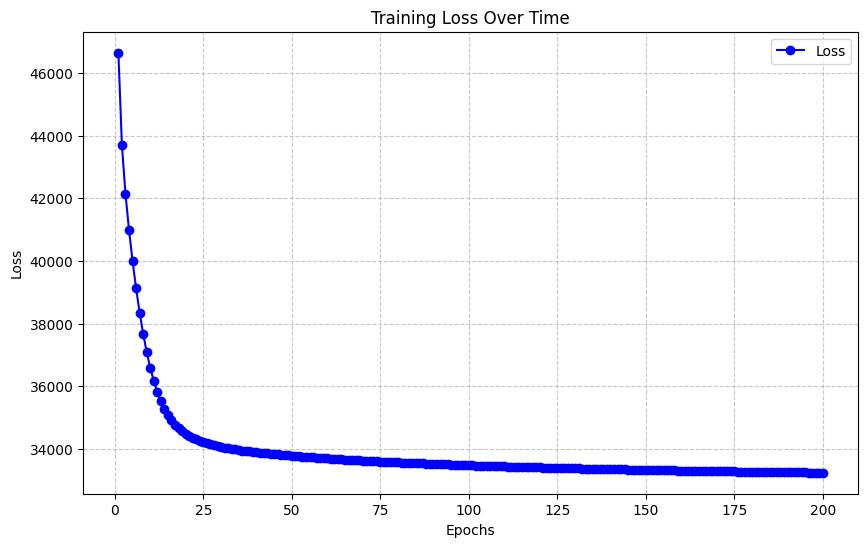

Word2Vec training complete.


In [59]:
# Hyperparameters
embedding_size = 10  # Size of the embedding vector
learning_rate = 0.1  # Reduced learning rate for stability
epochs = 200
clip_value = 5.0  # Gradient clipping threshold
epsilon = 1e-8  # Small value to prevent log(0)

# Vocabulary size (number of common words)
vocab_size = len(common_words_list)

# Initialize embeddings randomly (using Xavier initialization)
embeddings = np.random.uniform(
    -np.sqrt(6 / embedding_size), np.sqrt(6 / embedding_size), (vocab_size, embedding_size)
)


# Training loop
loss_values = []  # Store loss for each epoch

for epoch in range(epochs):
    total_loss = 0

    for word_id, contexts in enumerate(combined_context_vectors):
        # Skip if there are no valid contexts
        if all(c == -1 for c in contexts):
            continue

        target_vector = embeddings[word_id]  # Embedding for the target word
        positive_contexts = [c for c in contexts[:5] if c != -1]  # Positive context IDs
        negative_contexts = [c for c in contexts[5:] if c != -1]  # Negative context IDs

        # Positive examples
        for context_id in positive_contexts:
            context_vector = embeddings[context_id]
            dot_product = np.dot(target_vector, context_vector)
            prob = sigmoid(dot_product)
            loss = -np.log(prob + epsilon)  # Avoid log(0)
            total_loss += loss

            # Gradients and update
            grad_target = (prob - 1) * context_vector  # Gradient wrt target
            grad_context = (prob - 1) * target_vector  # Gradient wrt context

            # Gradient clipping
            grad_target = np.clip(grad_target, -clip_value, clip_value)
            grad_context = np.clip(grad_context, -clip_value, clip_value)

            # Update embeddings
            embeddings[word_id] -= learning_rate * grad_target
            embeddings[context_id] -= learning_rate * grad_context

        # Negative examples
        for context_id in negative_contexts:
            context_vector = embeddings[context_id]
            dot_product = np.dot(target_vector, context_vector)
            prob = sigmoid(dot_product)
            loss = -np.log(1 - prob + epsilon)  # Avoid log(0)
            total_loss += loss

            # Gradients and update
            grad_target = prob * context_vector  # Gradient wrt target
            grad_context = prob * target_vector  # Gradient wrt context

            # Gradient clipping
            grad_target = np.clip(grad_target, -clip_value, clip_value)
            grad_context = np.clip(grad_context, -clip_value, clip_value)

            # Update embeddings
            embeddings[word_id] -= learning_rate * grad_target
            embeddings[context_id] -= learning_rate * grad_context

    # Append epoch loss
    loss_values.append(total_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

# Plot the training loss
plot_loss(loss_values)

# Save the embeddings for future use
word_embeddings = {id_to_word[word_id]: embeddings[word_id] for word_id in range(vocab_size)}

print("Word2Vec training complete.")


# Model Preprocessing
- **Email to Vectors**
- **Choose 12 Best Common Word Vectors for embedding**
- **Pad with zero vectors if less**
- **4:1 Train Test Split**

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_email(email, word_embeddings, max_words=12):
    """
    Preprocess an email to create a fixed-size input vector of embeddings.

    Parameters:
        email (str): The email content.
        word_embeddings (dict): A dictionary with word embeddings.
        max_words (int): Maximum number of common words to use in the email.

    Returns:
        np.array: A flattened vector of size (max_words * embedding_size).
    """
    email = str(email)
    words = email.split()
    embeddings = []

    for word in words:
        if word in word_embeddings:
            embeddings.append(word_embeddings[word])

    # If there are more than max_words embeddings, truncate to max_words
    if len(embeddings) > max_words:
        embeddings = embeddings[:max_words]
    # If there are fewer than max_words, pad with zeros
    elif len(embeddings) < max_words:
        padding = [np.zeros(len(next(iter(word_embeddings.values()))))] * (max_words - len(embeddings))
        embeddings.extend(padding)

    return np.array(embeddings).flatten()

# Assuming word_embeddings is a pre-loaded dictionary of word embeddings
# Example usage: assuming 'balanced_df' is a DataFrame with 'email' and 'label' columns
X = np.array([preprocess_email(email, word_embeddings) for email in balanced_df['email']])
y = np.array(balanced_df['label'])

# Perform a 4:1 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (1600, 120), Testing set: (400, 120)


# Logistic Model
- **2 Hidden Layers with 8 Nodes**
- **Hidden Layers Activation: Relu**
- **Ouput Layer Activation: Sigmoid**
- **Loss function: Binary-Cross Entropy**
- **L2 Regularization**

Epoch 100/1500, Loss: 1.0396
Epoch 200/1500, Loss: 1.0071
Epoch 300/1500, Loss: 0.9799
Epoch 400/1500, Loss: 0.9573
Epoch 500/1500, Loss: 0.9387
Epoch 600/1500, Loss: 0.9235
Epoch 700/1500, Loss: 0.9111
Epoch 800/1500, Loss: 0.9008
Epoch 900/1500, Loss: 0.8923
Epoch 1000/1500, Loss: 0.8853
Epoch 1100/1500, Loss: 0.8794
Epoch 1200/1500, Loss: 0.8746
Epoch 1300/1500, Loss: 0.8707
Epoch 1400/1500, Loss: 0.8674
Epoch 1500/1500, Loss: 0.8648


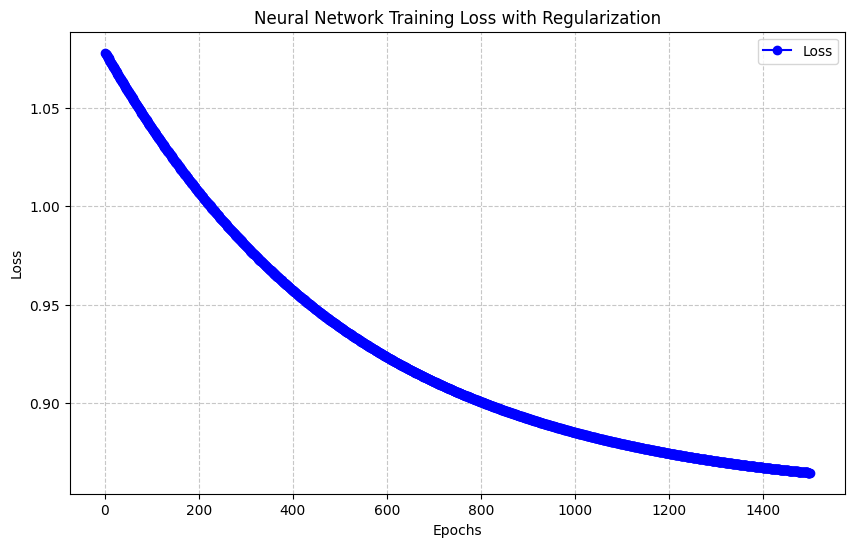

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
input_size = X.shape[1]
hidden_size = 8
output_size = 1
learning_rate = 0.001
epochs = 1500
lambda_reg = 0.01  # Regularization coefficient

# Xavier Initialization
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / (input_size + hidden_size))
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / (hidden_size + output_size))
b2 = np.zeros((1, output_size))



# Training loop
loss_values = []

for epoch in range(epochs):
    # Forward pass
    z1 = np.dot(X_train, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)

    # Compute loss with regularization
    loss = binary_cross_entropy(y_train, a2) + (lambda_reg / 2) * (np.sum(W1**2) + np.sum(W2**2))
    loss_values.append(loss)

    # Backward pass
    dz2 = a2 - y_train.reshape(-1, 1)
    dW2 = np.dot(a1.T, dz2) / X_train.shape[0] + lambda_reg * W2  # Include regularization
    db2 = np.mean(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(z1)
    dW1 = np.dot(X_train.T, dz1) / X_train.shape[0] + lambda_reg * W1  # Include regularization
    db1 = np.mean(dz1, axis=0, keepdims=True)

    # Update weights
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # Print loss periodically
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Plot loss
plot_loss(loss_values, title="Neural Network Training Loss with Regularization")


# Evaluation Metrics 
- **F-Score**
- **Accuracy**
- **Precision**
- **Recall**
- **Confusion Matrix**

Accuracy: 61.5000
Precision: 64.6707
Recall: 53.2020
F1-Score: 0.5838


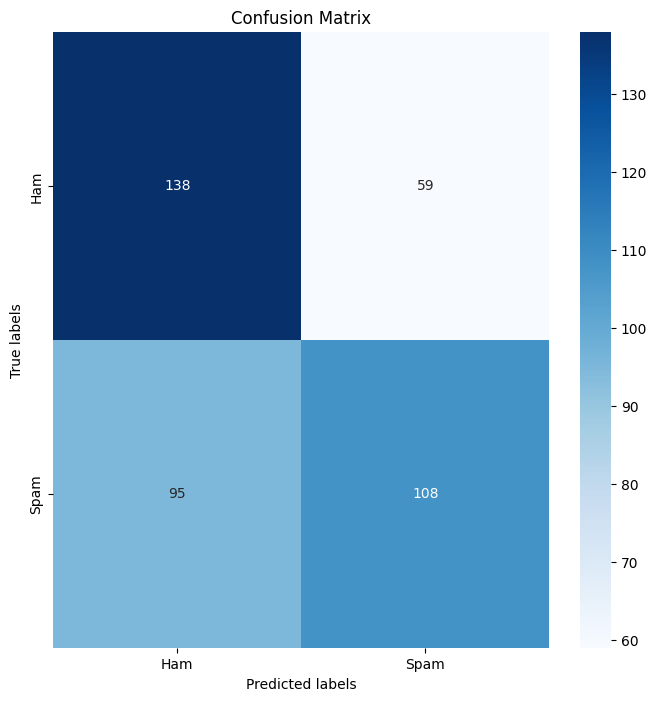

In [64]:
def predict(X, W1, b1, W2, b2):
    """
    Makes predictions using the trained weights and biases.
    """
    # Forward pass
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    
    # Convert probabilities to binary predictions (0 or 1)
    predictions = (a2 >= 0.5).astype(int)
    return predictions

def evaluate_model(X_test, y_test, W1, b1, W2, b2):
    """
    Evaluates the model on the test set and prints evaluation metrics.
    """
    # Get predictions
    predictions = predict(X_test, W1, b1, W2, b2)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    # Print metrics
    print(f"Accuracy: {accuracy*100:.4f}")
    print(f"Precision: {precision*100:.4f}")
    print(f"Recall: {recall*100:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, cm


# Evaluate the model on the test set
accuracy, precision, recall, f1, cm = evaluate_model(X_test, y_test, W1, b1, W2, b2)



plot_confusion_matrix(cm, ['Ham', 'Spam'])